# Prediction of Mutations to Control Pathways Enabling Tumour Cell Invasion with the CoLoMoTo Interactive Notebook (Tutorial)

**Authors**: Nicolas Levy<sup>1,2</sup>, Gautier Stoll<sup>3</sup>, Aurélien Naldi<sup>4</sup>, Céline Hernandez<sup>4</sup>, Denis Thieffry<sup>4</sup>, Andrei Zinovyev<sup>5</sup>, Laurence Calzone<sup>5</sup>, Loïc Paulevé<sup>1</sup>
> <sup>1</sup> LRI UMR 8623, Université Paris-Sud, CNRS, Université Paris-Saclay, Orsay, France;
> <sup>2</sup> École normale supérieure de Lyon, France;
> <sup>3</sup> Universite Paris Descartes/Paris V, Sorbonne Paris Cite, INSERM, U1138, Paris, France;
> <sup>4</sup> Computational Systems Biology Team, Institut de Biologie de l’Ecole Normale Supérieure, CNRS UMR8197, INSERM U1024, École Normale Supérieure, PSL Research University, Paris, France;
> <sup>5</sup> Institut Curie, PSL Research University, INSERM, U900, Mines Paris Tech, Paris France;


### Abstract

> Based on a Boolean network of the pathways enabling tumor cell invasion, we combine several softwares to predict mutations that would either enforce or prevent a metastatic phenotype.
>
> Our analysis combines (1) the importation of the qualitative model from the Cell Collective web service, (2) its format conversion using the Java library BioLQM, (3) the formal prediction of mutations using the OCaml software Pint, (4) the model checking using the C++ software NuSMV, (5) quantitative stochastic simulations using the C++ software MaBoSS, and (6) the visualisation of results using the python libraries pandas and matplotlib.
We rely on the CoLoMoTo Interactive Notebook to provide a thoroughly documented and executable notebook of our computational analysis.
>
> This tutorial illustrates how the integration of the aforementioned tools in the Jupyter notebook web interface and its Docker distribution greatly facilitate the production of accessible and reproducible model analysis workflows.


### Notebook preparation

We import the different modules that are used in the notebook:

In [1]:
import ginsim
import biolqm
import maboss
import pypint

You are using Pint version 2017-12-19 and pypint 1.3.93

API is documented at https://loicpauleve.name/pint/doc/api.html

## Model input

We analyse the model published by Cohen et al. in PLOS Computational Biology in 2015 (http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004571).
The GINML file is available on http://ginsim.org/node/191. The model is also available on CellCollective at https://cellcollective.org/#5884/tumour-cell-invasion-and-migration.

We first show how to use GINsim to fetch the GINML file and display the regulatory graph:

In [2]:
lrg = ginsim.open("http://ginsim.org/sites/default/files/SuppMat_Model_Master_Model.zginml")

Downloading 'http://ginsim.org/sites/default/files/SuppMat_Model_Master_Model.zginml' to 'gen/colomotoegmwqyvaSuppMat_Model_Master_Model.zginml'

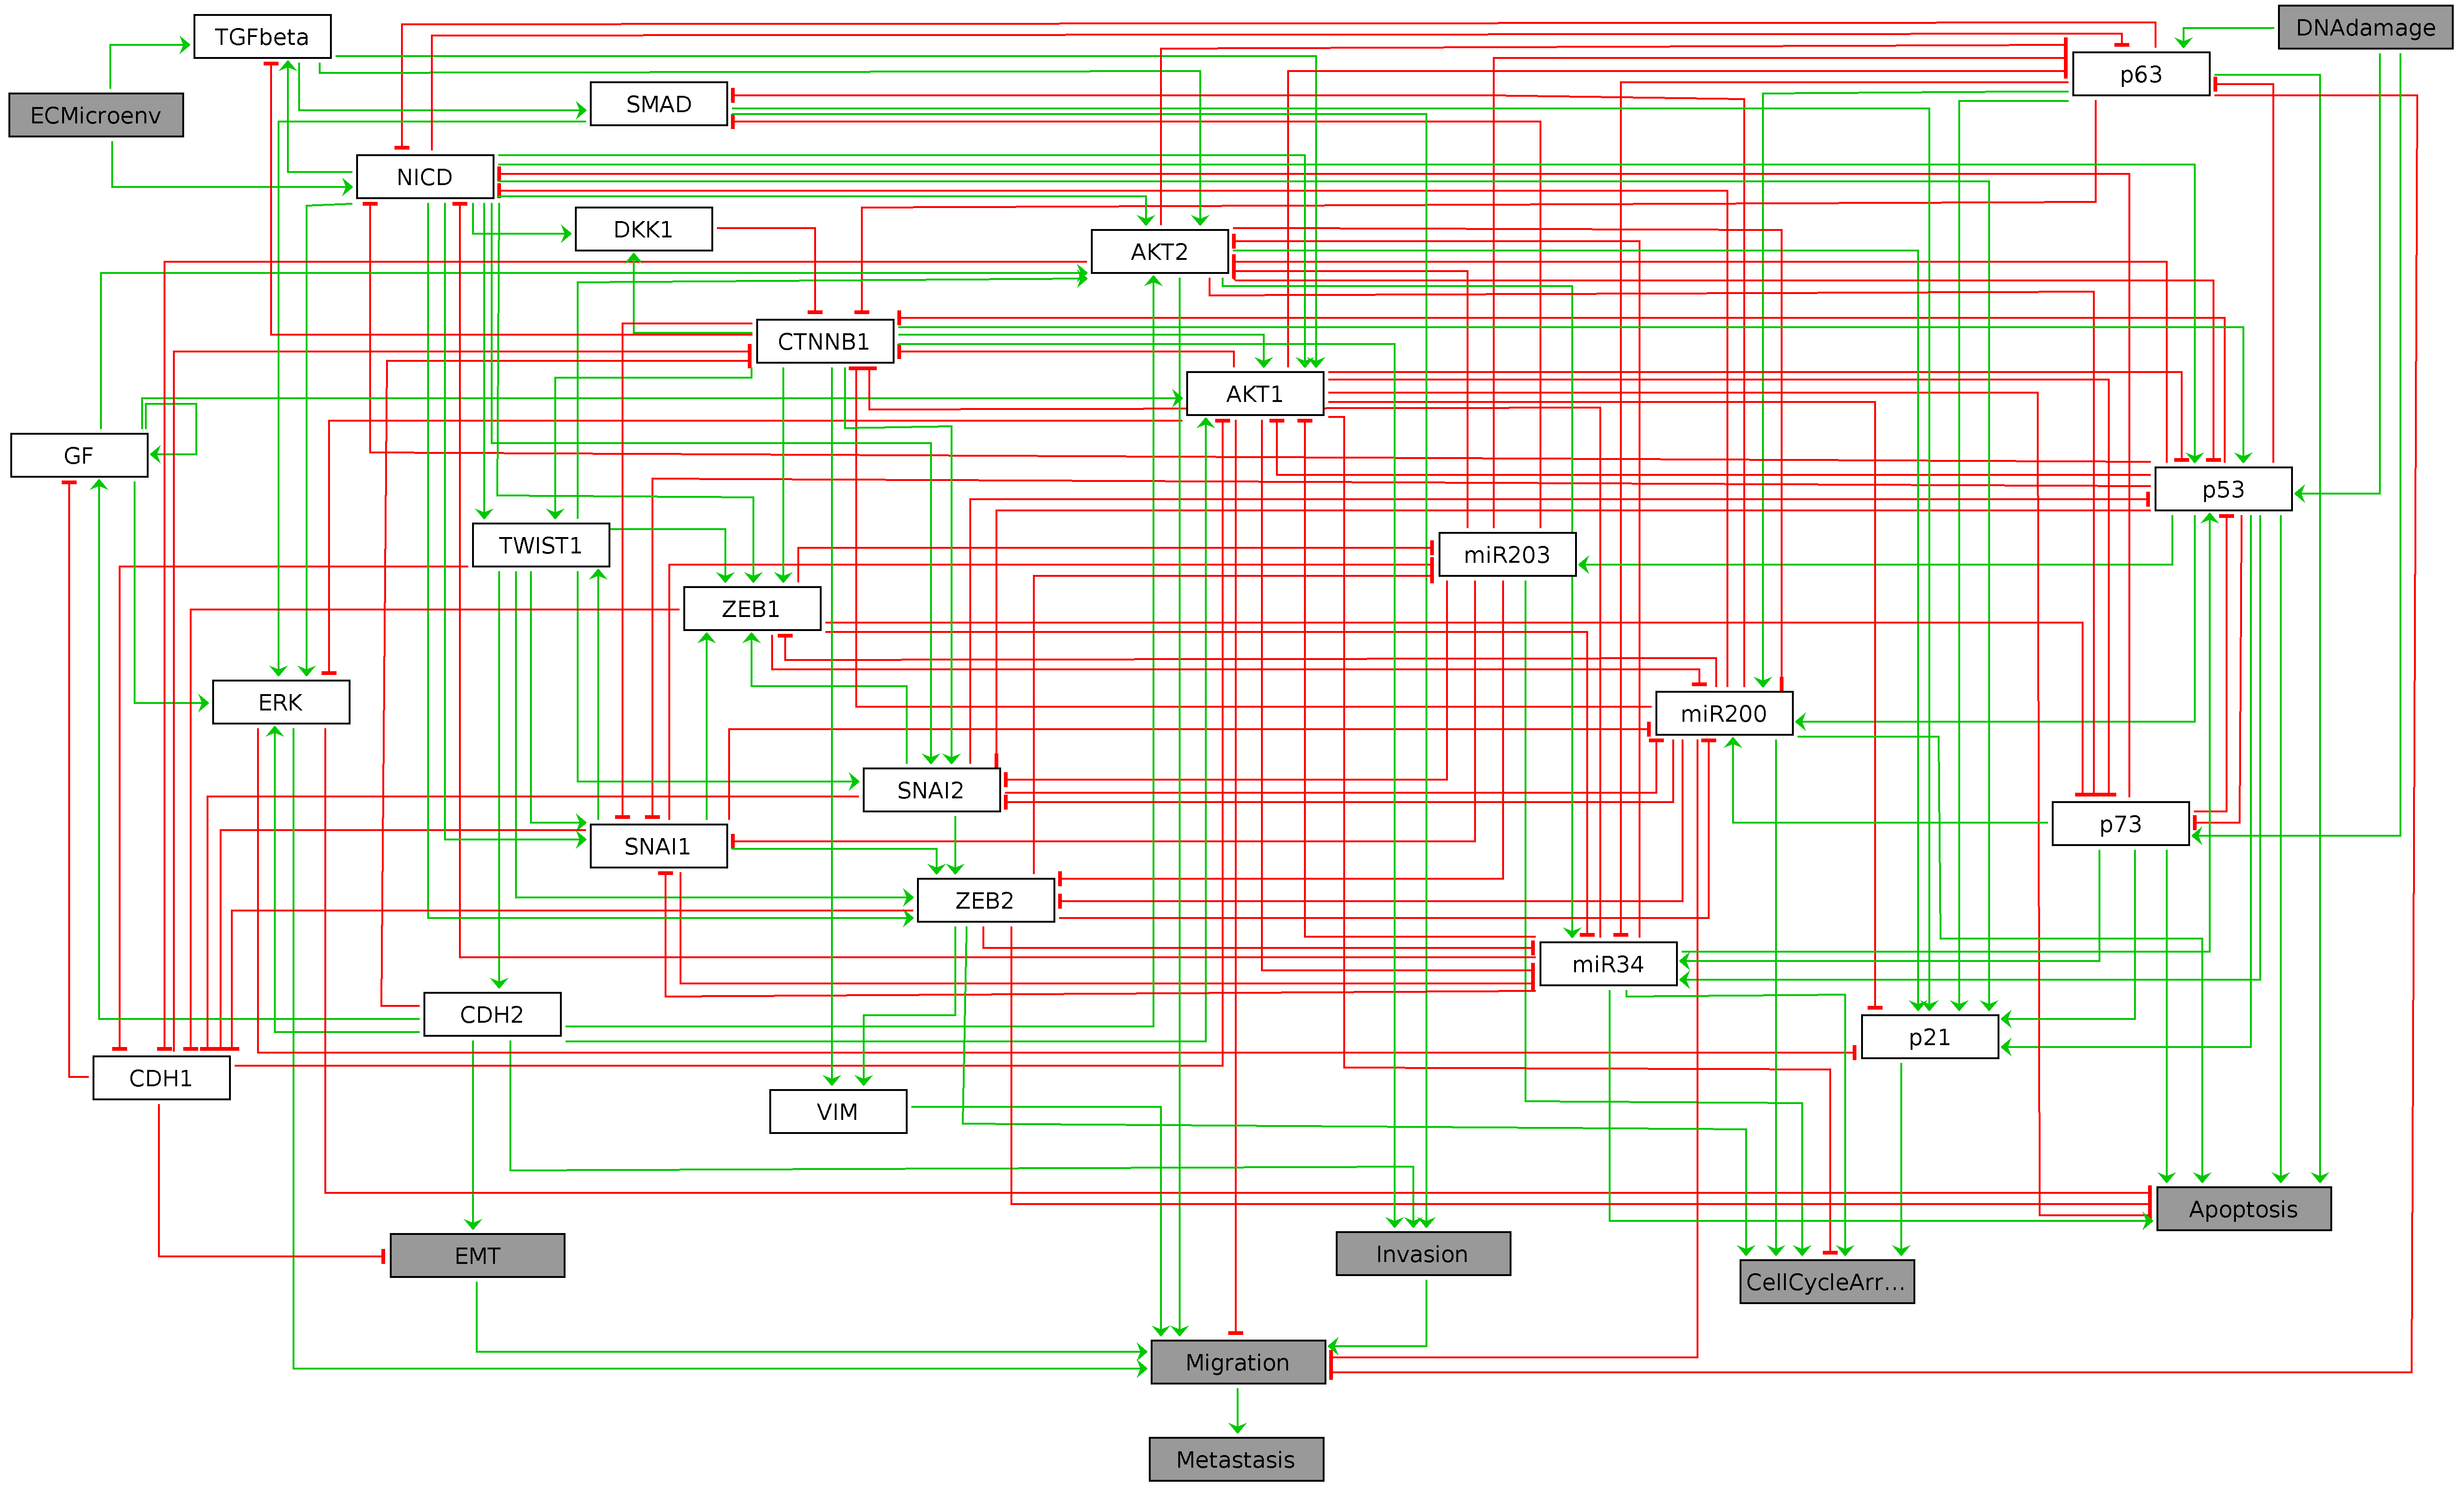

In [3]:
ginsim.show(lrg)

Alternatively, the model can be imported in SBML format from CellCollective using bioLQM:

In [4]:
lqm = biolqm.loadModel("https://cellcollective.org/#5884/tumour-cell-invasion-and-migration")

Downloading 'http://api.cellcollective.org/model/export/5884?type=SBML' to 'gen/colomotoo2xw2gvr5884.sbml'

## Analysis using stochastic simulations

We use MaBoSS to approximate the steady states distribution using stochastic simulations.

First, we convert the bioLQM model to MaBoSS:

In [5]:
wt_sim = biolqm.to_maboss(lqm, simulation_name="wt")

### Simulation setup
#### Initial states

In [6]:
active_nodes = ["miR200", "miR203", "miR34"]
anystate_nodes = ["ECM", "DNAdamage", "GF", "TGFbeta"]
inactive_nodes = set(wt_sim.network.keys()).difference(active_nodes).difference(anystate_nodes) 

In [7]:
for n in active_nodes:
    wt_sim.network.set_istate(n, [0, 1])
for n in anystate_nodes:
    wt_sim.network.set_istate(n, [0.5, 0.5])
for n in inactive_nodes:
    wt_sim.network.set_istate(n, [1, 0])

#### Output

In [8]:
wt_sim.network.set_output(('Metastasis', 'Migration', 'Invasion', 'EMT', 'Apoptosis', 'CellCycleArrest'))

#### Simulation parameters

In [9]:
wt_sim.update_parameters(discrete_time=0, use_physrandgen=0,
                                    seed_pseudorandom=100, sample_count=50000,
                                    max_time=50, time_tick=0.1, thread_count=4,
                                    statdist_traj_count=100, statdist_cluster_threshold=0.9)

### Simulation of wild-type model

In [10]:
wt_results = wt_sim.run()

MaBoSS ended successfuly


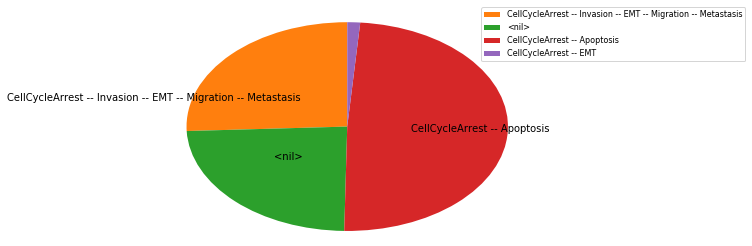

In [11]:
wt_results.plot_piechart()

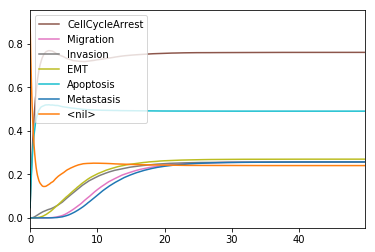

In [12]:
wt_results.plot_node_trajectory()

### Simulation of Notch+/p53- mutant

In [13]:
mut_sim = wt_sim.copy("mutant1")
mut_sim.mutate("p53", "OFF")
mut_sim.mutate("NICD", "ON")

In [14]:
mut_sim.network.set_istate("NICD", [0, 1]) # XXX should not be necessary

In [15]:
mut_results = mut_sim.run()

MaBoSS ended successfuly


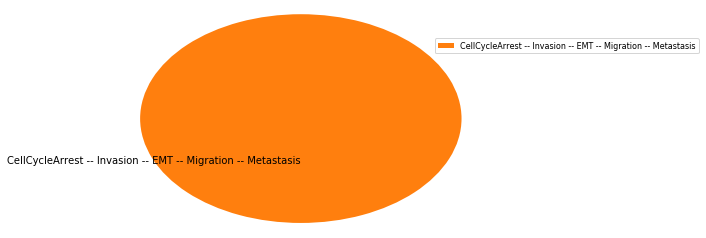

In [16]:
mut_results.plot_piechart()

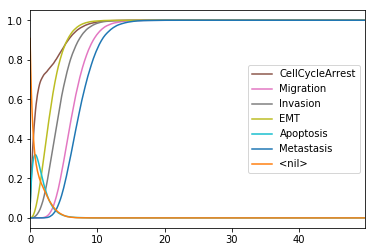

In [27]:
mut_results.plot_node_trajectory()

## Formal analysis with Pint

### Wild-type

In [17]:
an = biolqm.to_pint(lqm)

Source file is in Automata Network (an) format

In [18]:
for n in active_nodes:
    an.initial_state[n] = 1
for n in anystate_nodes:
    an.initial_state[n] = {0, 1}

In [19]:
goal = pypint.Goal("Apoptosis=1")

In [20]:
an.reachability(goal)

True

In [21]:
from colomoto.temporal_logics import *
specs = {
    "reach-apoptosis": EF(S(Apoptosis=1)),
    "stable-apoptosis": EF(AG(S(Apoptosis=1)))
}

In [ ]:
smv = an.to_nusmv(skip_init=False)
smv.add_ctls(specs)
smv.verify()

### Notch+/p53- mutant

In [22]:
mut_an = an.lock(NICD=1, p53=0)

In [29]:
mut_an.having(TGFbeta=0).reachability(goal)

True

In [24]:
smv = mut_an.to_nusmv(skip_init=False)
smv.add_ctls(specs)
smv.verify()

{'reach-apoptosis': True, 'stable-apoptosis': False}

# computing graph layout...


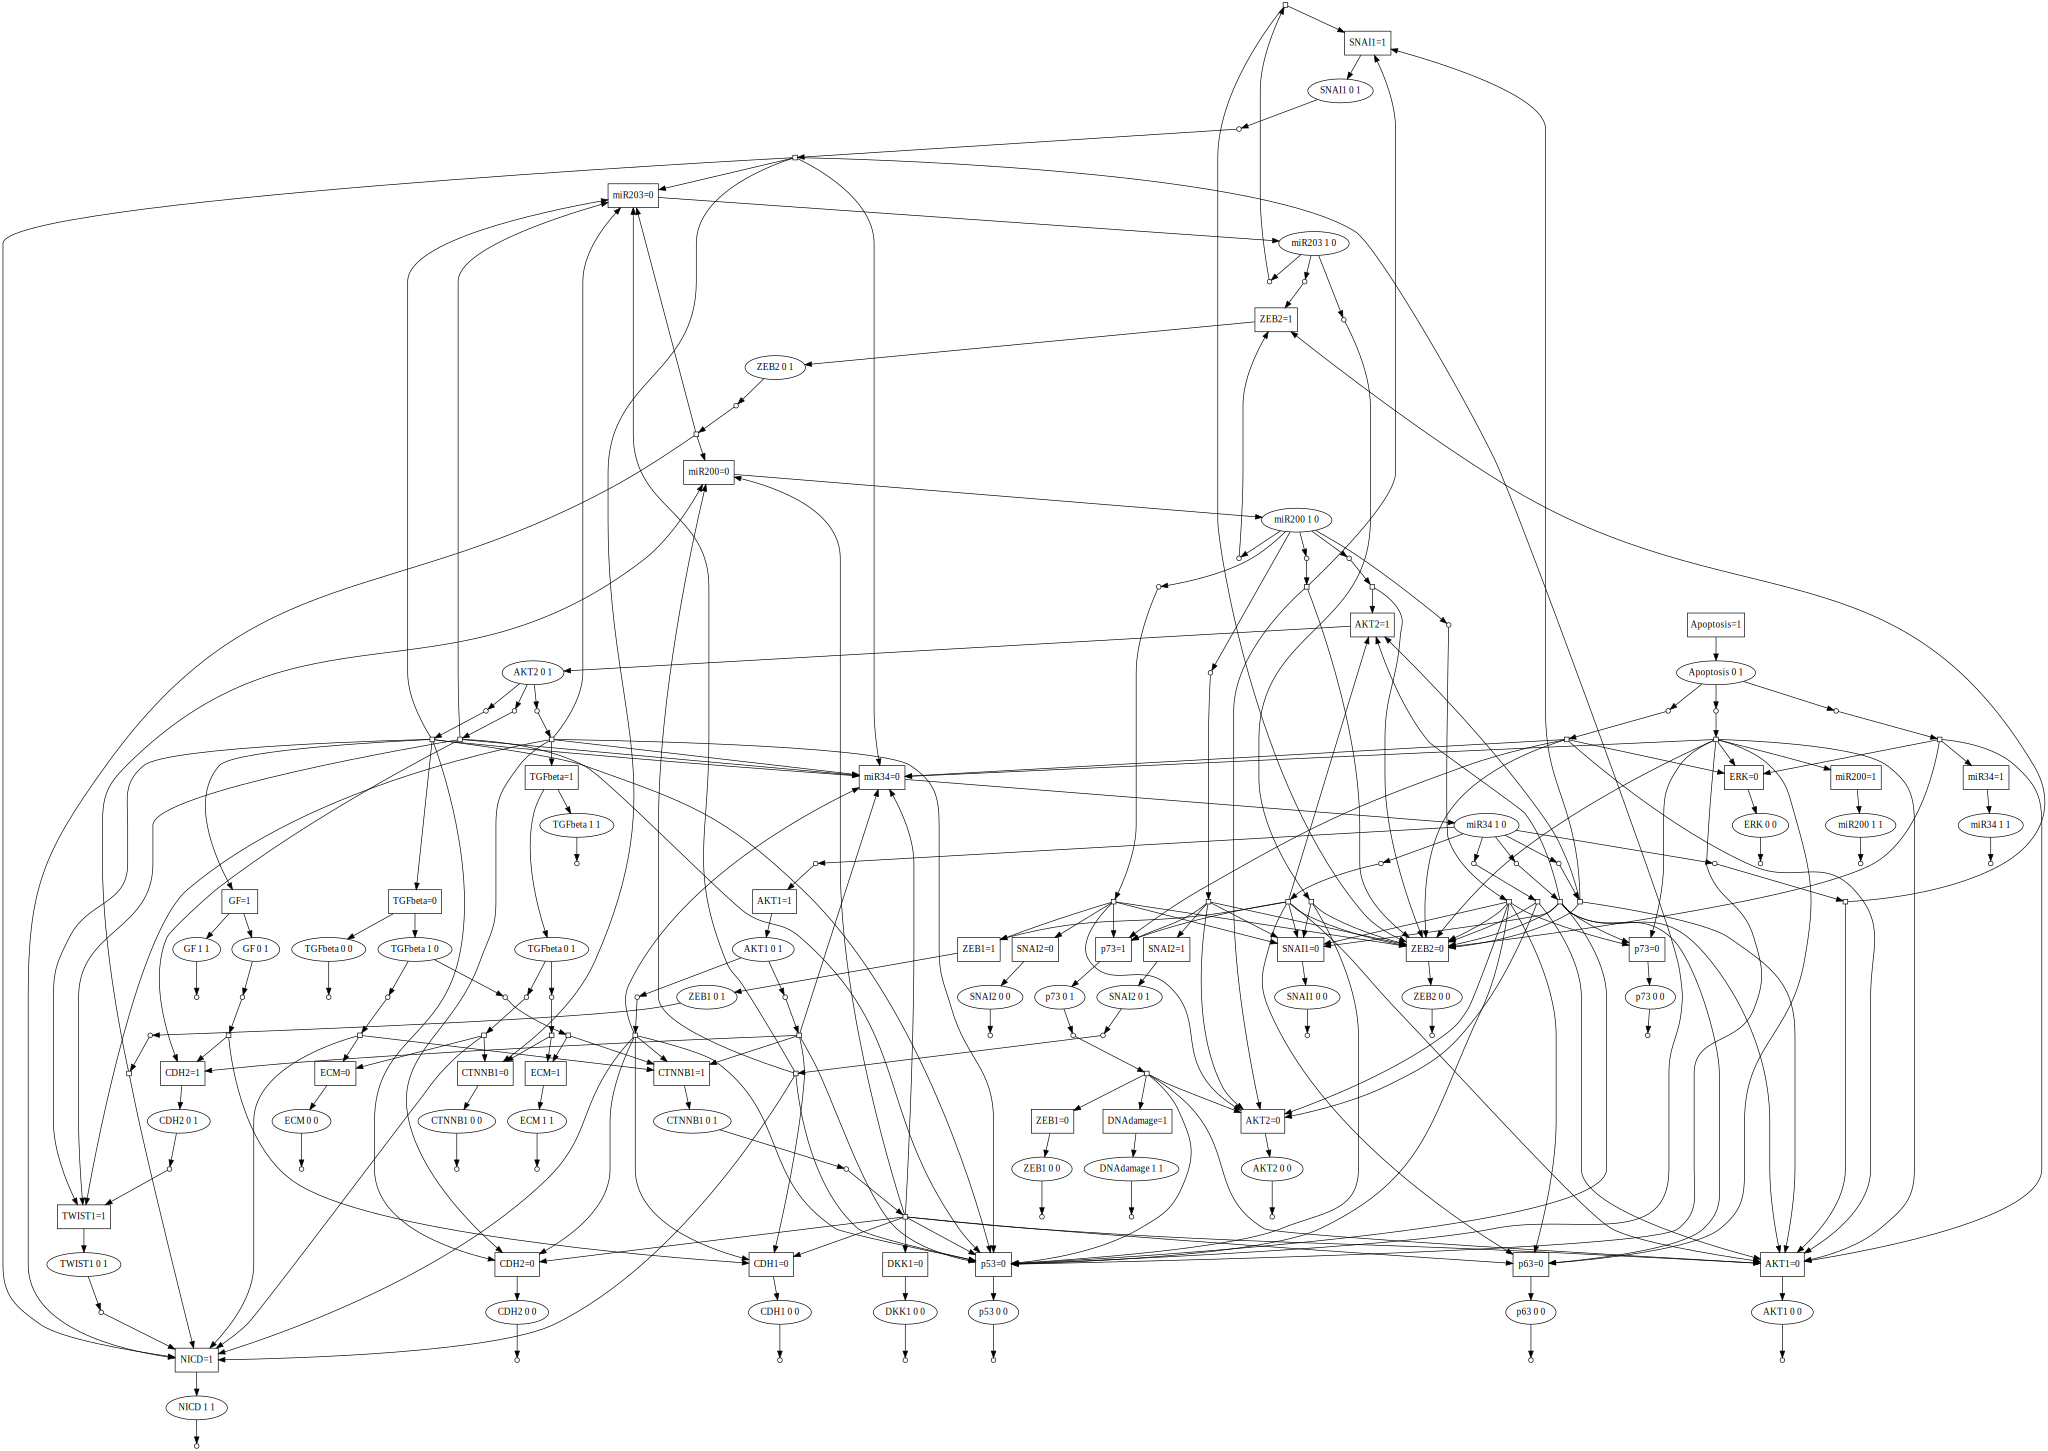

In [25]:
mut_an.simple_lcg(goal)